In [1]:
import numpy as np
import librosa
from scipy.fftpack import dct

def bfcc(
    data,
    sr=22050,
    n_fft=512,
    hop_length=None,
    win_length=None,
    n_bark=13,
    n_ceps=13
):
    """
    Compute Bark-Frequency Cepstral Coefficients (BFCC)
    """
    if hop_length is None:
        hop_length = int(0.01 * sr)
    if win_length is None:
        win_length = int(0.025 * sr)

    # STFT
    S = np.abs(librosa.stft(data, n_fft=n_fft, hop_length=hop_length, win_length=win_length))**2

    # approximate Bark scale
    def bark_scale(f):
        return 13 * np.arctan(0.00076 * f) + 3.5 * np.arctan((f/7500.0)**2)

    bark_bins = bark_scale(np.linspace(0, sr/2, n_fft//2+1))
    bark_fbanks = np.zeros((n_bark, len(bark_bins)))

    edges = np.linspace(bark_bins.min(), bark_bins.max(), n_bark+2)
    for i in range(n_bark):
        left, center, right = edges[i], edges[i+1], edges[i+2]
        bark_fbanks[i] = np.maximum(0, 1 - np.abs(bark_bins - center) / (center - left))

    # filterbank energies
    bark_energies = np.dot(bark_fbanks, S)

    # log
    log_bark = np.log(bark_energies + 1e-8)

    # DCT
    bfcc_feats = dct(log_bark, axis=0, type=2, norm='ortho')[:n_ceps, :].T  # (frames, n_ceps)

    return bfcc_feats


In [2]:
import numpy as np
from scipy.io import wavfile
import librosa
from python_speech_features import mfcc
from scipy.fftpack import dct
import speechpy

rate, data = wavfile.read(
    r"..\Dataset\Red-Palm-Weevil-Detection-KAUST-main\audio_dataset\clean\F_20200218000001_17_T8.6.wav"
)

data = data.astype(np.float32)
data /= np.max(np.abs(data))

mfcc_feats = mfcc(
    signal=data,
    samplerate=rate,
    winlen=0.025,
    winstep=0.01,
    numcep=13,
    nfilt=40,
    nfft=512
)



CQT = librosa.cqt(data, sr=rate, n_bins=60, fmin=20)
logCQT = librosa.amplitude_to_db(np.abs(CQT))
cqcc_feats = dct(logCQT, axis=0, type=2, norm='ortho')[:13, :].T



bfcc_features = bfcc(data, sr=rate)
print("MFCC shape:", mfcc_feats.shape)
print("CQCC shape:", cqcc_feats.shape)
print("BFCC shape:", bfcc_features.shape)


MFCC shape: (1999, 13)
CQCC shape: (313, 13)
BFCC shape: (2001, 13)


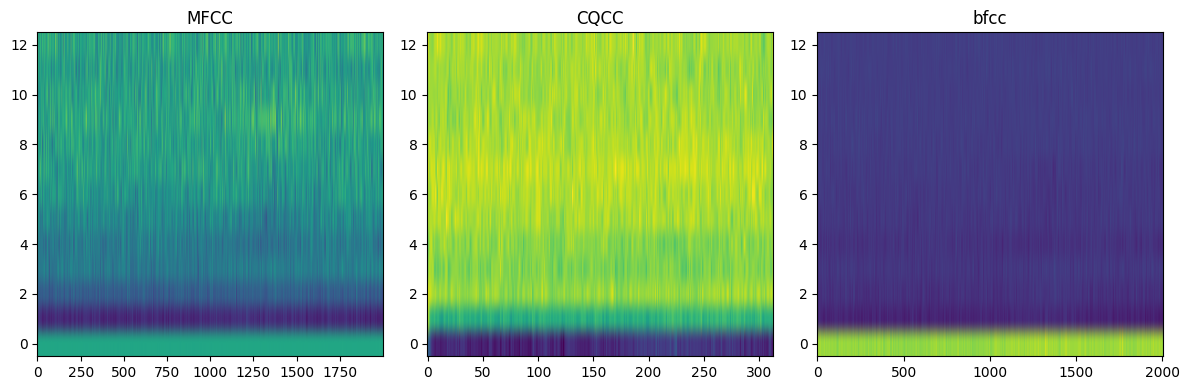

In [4]:
# 7️⃣ Optional visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(mfcc_feats.T, origin="lower", aspect="auto")
plt.title("MFCC")

plt.subplot(1,3,2)
plt.imshow(cqcc_feats.T, origin="lower", aspect="auto")
plt.title("CQCC")

plt.subplot(1,3,3)
plt.imshow(bfcc_features.T, origin="lower", aspect="auto")
plt.title("bfcc")
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'MFCC')

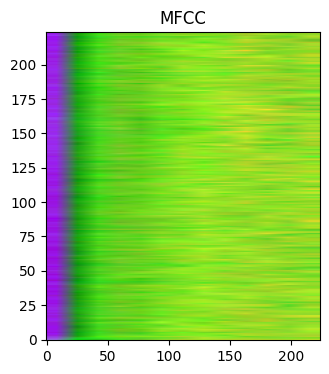

In [9]:
# aggregate the three

import cv2
def resize_feature(feat, target_height=224, target_width=224):
    """
    Resize a 2D feature matrix to (target_height, target_width).
    """
    # scale to 0-255 for visualization consistency
    feat_norm = cv2.normalize(feat, None, 0, 255, cv2.NORM_MINMAX)
    feat_uint8 = feat_norm.astype(np.uint8)
    resized = cv2.resize(feat_uint8, (target_width, target_height), interpolation=cv2.INTER_LINEAR)
    return resized

mfcc_feats = resize_feature(mfcc_feats)
cqcc_feats = resize_feature(cqcc_feats)
bfcc_features = resize_feature(bfcc_features)

# Create three channels of features
features_image = np.stack([mfcc_feats, cqcc_feats, bfcc_features], axis=0)  # shape (3, 224, 224)

stacked_for_display = np.transpose(features_image, (1, 2, 0))  # (224, 224, 3)

# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(stacked_for_display, origin="lower", aspect="auto")
plt.title("MFCC")

In [47]:
import os
infested = os.listdir(r"..\Dataset\Red-Palm-Weevil-Detection-KAUST-main\audio_dataset\infested")
clean = os.listdir(r"..\Dataset\Red-Palm-Weevil-Detection-KAUST-main\audio_dataset\clean")
print(len(infested), len(clean))

1300 1283


In [54]:
import pandas as pd
df = pd.DataFrame(columns=['filename', 'label'])
data_path = "../Dataset/Red-Palm-Weevil-Detection-KAUST-main/audio_dataset/"
df['filename'] = infested + clean
df['filename'] = df['filename'].apply(lambda x: "infested/" + x if x in infested else "clean/" + x)
df['filename'] = df['filename'].apply(lambda x: data_path + x)
df['label'] = [1]*len(infested) + [0]*len(clean)
df.to_csv(r"..\Dataset\Red-Palm-Weevil-Detection-KAUST-main\audio_dataset\labels.csv", index=False)

In [56]:
df.head(2)

,filename,label
0,../Dataset/Red-Palm-Weevil-Detection-KAUST-mai...,1
1,../Dataset/Red-Palm-Weevil-Detection-KAUST-mai...,1
